# Headers (load libaries/packages/functions needed)

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pylab import *
import h5py
import numpy as np
import pandas as pd
import scipy.io as sio
import time
from IPython.display import Markdown, HTML, display
from pyitlib import discrete_random_variable as drv

pass

In [3]:
# Define some plotting styles that we will use.
fontSize=15
matplotlib.rcParams.update({"axes.formatter.limits": (-4,4),'font.family':'Avenir','font.size': fontSize, "axes.titlesize": fontSize, "xtick.labelsize": fontSize, "ytick.labelsize": fontSize,})
plotStyles={"markersize":12,"markeredgewidth":2.0,"linewidth":2.0}
stepStyles={"markersize":15,"markeredgewidth":3.0,"linewidth":4.0,"where":"post"}
scatterStyles={"linewidth":1.0}

# 1 load files

Here we load the .mat files (provided by Tianyou) to python. We merge the datasets from the 2018/10/10 experiment and the 2018/12/01 experiment. We look at the samples collected at different times after triggering (1,2,3,5,7.5,10,20,30,60,120,180 min). For each cell, we extract the following data:

* Par spot number (estimation of MOI)
* cell length
* cI mRNA copy number
* cII mRNA copy number
* cro mRNA copy number

In [4]:
column_names = ['len','moi','ci','cro','cii','time']
df = pd.DataFrame(columns = column_names)

#####################
#filename1 = '20181010_infection_dataset_ty.mat'
filename2 = '20181201_infection_dataset_ty.mat'

time_after_triggering = [0.5,1,2,3,5,7.5,10,20,30,60,120,180]
column_id = [3,4,16,26,36]
for filename in [filename2]:
    mat_contents = sio.loadmat(filename)['enlistcell_total'];
    k = 0;
    for i in range(2,2+len(time_after_triggering)):
        tmp = mat_contents[0][i][:,column_id]
        tmp2=tmp[~np.isnan(tmp).any(axis=1)]
        tmp2=tmp2[tmp2[:,1]>0]
        df_tmp = pd.DataFrame(data=tmp2, 
                              index=[str(time_after_triggering[k])+'_'+str(i) for i in range(1,len(tmp2)+1)], 
                              columns=['len','moi','ci','cro','cii'])
        df_tmp['time']=np.full((len(tmp2),1),time_after_triggering[k])
        df = pd.concat([df,df_tmp])
        k = k+1;

df['len']=df['len']/(df['len'].median())
df['conc']= df['moi']/df['len']


In [5]:
df1 = df
df1['time'] = df['time']+2.5;

In [6]:
df2 = df1[df1['time']==5.5];
df3 = df1[df1['time']==22.5]; 

# 1 Linear projection

## t = 5.5 min

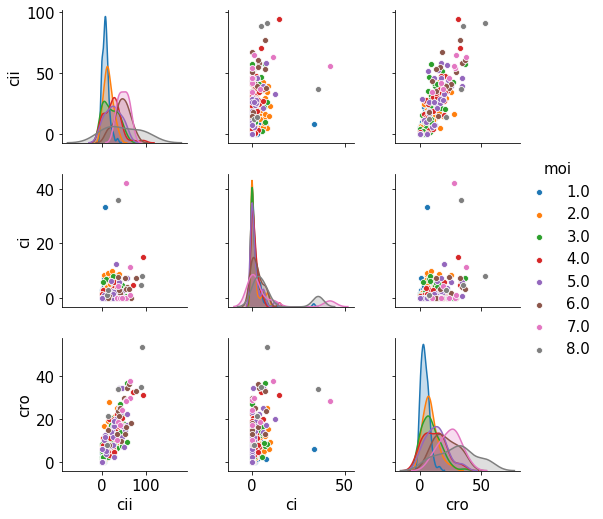

In [159]:
import seaborn as sns

df_t = df2[['cii','ci','cro','moi']]
df_t = df_t[df_t['moi']<=8]
df_t.moi.value_counts()
sns.pairplot(df_t, hue='moi',vars=['cii','ci','cro'])

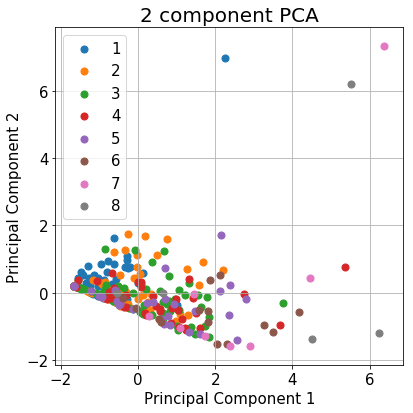

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['cii', 'cro', 'ci']
x = df_t.loc[:, features].values
y = df_t.loc[:,['moi']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, df_t[['moi']].reset_index()], axis = 1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2,3,4,5,6,7,8]
#colors = ['#CC9966','#FF6633','#CC0033','#990033','#660033']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey'];
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['moi'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
tight_layout()

## t = 22.5 min

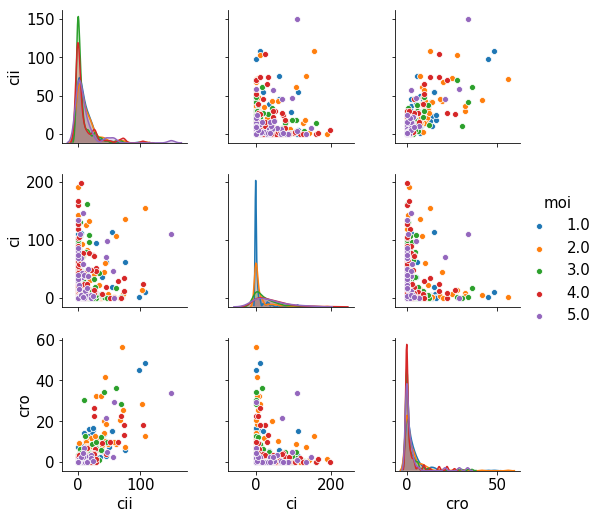

In [115]:
df_t = df3[['cii','ci','cro','moi']]
df_t = df_t[df_t['moi']<=5]
df_t.moi.value_counts()
sns.pairplot(df_t, hue='moi',vars=['cii','ci','cro'])


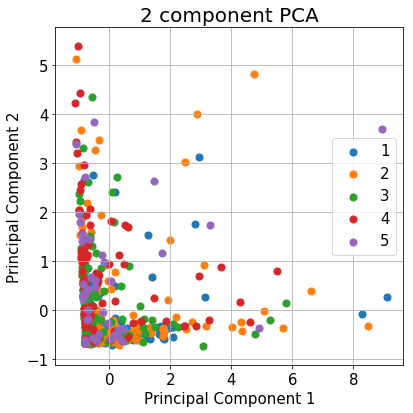

In [116]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

features = ['cii', 'cro', 'ci']
x = df_t.loc[:, features].values
y = df_t.loc[:,['moi']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, df_t[['moi']].reset_index()], axis = 1)
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1,2,3,4,5]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple'];
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['moi'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
tight_layout()

# 2 Nonlinear projection

In [129]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

features = ['cii', 'cro', 'ci']
X = df2.loc[:, features].values
Y = df2.loc[:,['moi']].values
for i in range(0,len(Y)):
    if Y[i] in [1,2,3]:
        Y[i] = 1;
    elif Y[i] in [4,5]:
        Y[i] = 2;
    elif Y[i] in [6,7]:
        Y[i] = 3;
    elif Y[i] in [8]:
        Y[i] = 4;
    else:
        Y[i] = 5;

X = StandardScaler().fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)


In [150]:
def baseline_model():
    model = Sequential()
    model.add(Dense(400, input_dim=3, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(50,activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=2000, verbose=0)
#kfold = KFold(n_splits=5, shuffle=True)
#results = cross_val_score(estimator, X, dummy_y, cv=kfold)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

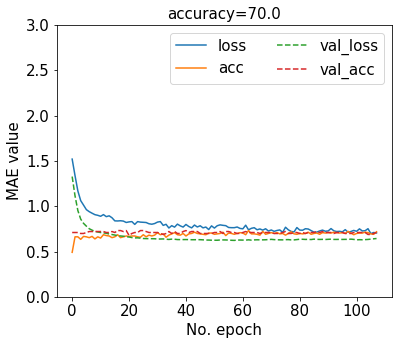

In [151]:
def plot_history(history, my_title):
    plot(history.history['loss'],label='loss')
    plot(history.history['categorical_accuracy'],label='acc')
    plot(history.history['val_loss'], '--', label='val_loss')
    plot(history.history['val_categorical_accuracy'], '--', label='val_acc')
    plt.title(my_title)
    ylabel('MAE value')
    xlabel('No. epoch')
    ylim((0,3))
    legend(loc='best',ncol=2)
    
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)   
#history = estimator.fit(X, dummy_y, validation_split=0.3, shuffle=True, epochs=2000)
history = estimator.fit(X, dummy_y, validation_split=0.3, shuffle=True, callbacks=[es_callback])    
matplotlib.rcParams.update({"figure.figsize": (6,5)})
plot_history(history,'accuracy='+str(round(np.mean(history.history['categorical_accuracy'][-10:])*100,0)))  


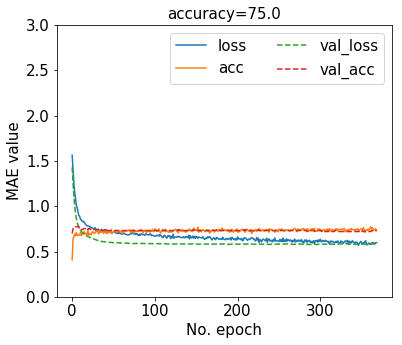

In [160]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

features = ['cii', 'cro', 'ci']
X = df2.loc[:, features].values
Y = df2.loc[:,['moi']].values
for i in range(0,len(Y)):
    if Y[i] in [1,2,3]:
        Y[i] = 1;
    elif Y[i] in [4,5,6]:
        Y[i] = 2;
    elif Y[i] in [7]:
        Y[i] = 3;
    elif Y[i] in [8]:
        Y[i] = 4;
    else:
        Y[i] = 5;

X = StandardScaler().fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

def baseline_model():
    model = Sequential()
    model.add(Dense(400, input_dim=3, activation='relu'))
    model.add(Dropout(0.5))
    
#    model.add(Dense(50,activation='relu'))
#    model.add(Dropout(0.2))
    
    model.add(Dense(5, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=2000, verbose=0)

def plot_history(history, my_title):
    plot(history.history['loss'],label='loss')
    plot(history.history['categorical_accuracy'],label='acc')
    plot(history.history['val_loss'], '--', label='val_loss')
    plot(history.history['val_categorical_accuracy'], '--', label='val_acc')
    plt.title(my_title)
    ylabel('MAE value')
    xlabel('No. epoch')
    ylim((0,3))
    legend(loc='best',ncol=2)
    
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)   
history = estimator.fit(X, dummy_y, validation_split=0.3, shuffle=True, callbacks=[es_callback])    
matplotlib.rcParams.update({"figure.figsize": (6,5)})
plot_history(history,'accuracy='+str(round(np.mean(history.history['categorical_accuracy'][-10:])*100,0)))  


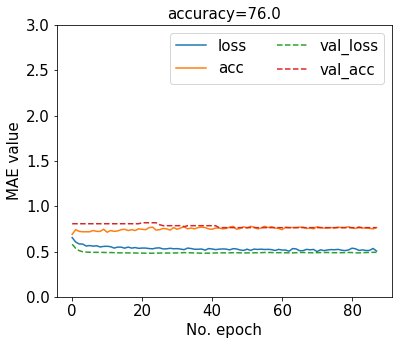

In [167]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

features = ['cii', 'cro', 'ci']
X = df2.loc[:, features].values
Y = df2.loc[:,['moi']].values
for i in range(0,len(Y)):
    if Y[i] in [1,2,3]:
        Y[i] = 1;
    elif Y[i] in [4,5,6]:
        Y[i] = 2;
    else:
        Y[i] = 2;
X = StandardScaler().fit_transform(X)

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

def baseline_model():
    model = Sequential()
    model.add(Dense(400, input_dim=3, activation='relu'))
    model.add(Dropout(0.5))
    
#    model.add(Dense(50,activation='relu'))
#    model.add(Dropout(0.2))
    
    model.add(Dense(2, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=2000, verbose=0)

def plot_history(history, my_title):
    plot(history.history['loss'],label='loss')
    plot(history.history['categorical_accuracy'],label='acc')
    plot(history.history['val_loss'], '--', label='val_loss')
    plot(history.history['val_categorical_accuracy'], '--', label='val_acc')
    plt.title(my_title)
    ylabel('MAE value')
    xlabel('No. epoch')
    ylim((0,3))
    legend(loc='best',ncol=2)
    
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)   
history = estimator.fit(X, dummy_y, validation_split=0.3, shuffle=True, callbacks=[es_callback])    
matplotlib.rcParams.update({"figure.figsize": (6,5)})
plot_history(history,'accuracy='+str(round(np.mean(history.history['categorical_accuracy'][-10:])*100,0)))  
